In [8]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [9]:
from src.nas.mlp_chromosome import RawChromosome


RawChromosome.get_bounds()

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), array([7, 8, 3, 7, 2, 3, 1, 1, 6, 3]))

In [10]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import MlpNasParams
from src.datasets.vertebral_dataset import VertebralDataset


params = MlpNasParams(
    epochs=3,
    patience=5,
    amount_of_evaluations=1,
    population_size=30,
    population_offspring_count=10,
    algorithm_generations=3,
    population_store_file="population.csv",
)
problem = MlpNasProblem(params, VertebralDataset)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl


(162.0, np.float64(2851.2))

In [11]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file is empty. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |      3 |             - |             -
     2 |       40 |      3 |  0.1333333333 |         nadir
     3 |       50 |      2 |  2.0000000000 |         nadir
Solutions: [[5 7 3 5 1 0 1 0 5 0]
 [2 8 0 0 1 1 1 0 5 3]]
Objectives: [[-0.77419355  1.        ]
 [-0.69354839  0.        ]]


In [12]:
from dataclasses import asdict

from pprint import pprint
import pandas as pd


df = pd.DataFrame()

for i in range(len(res.X)):
    x = res.X[i]
    f = res.F[i]
    accuracy = problem.denormalize(-f[0], 0, 100)
    complexity = problem.denormalize(
        f[1], problem.get_min_complexity(), problem.get_max_complexity()
    )
    ch = RawChromosome(x).parse()
    params = problem.get_nn_params(ch)

    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [
                    {
                        "Accuracy": accuracy,
                        "Complexity": complexity,
                        **asdict(params),
                        "Chromosome": x,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

df

,Accuracy,Complexity,in_height,hidden_height,out_height,hidden_layers,in_bitwidth,hidden_bitwidth,activation,dropout_rate,learning_rate,weight_decay,epochs,quantization_mode,Chromosome
0,77.419355,2851.2,6,7,3,3,6,6,ActivationModule.RELU,0.1,0.005,0.010,3,QMode.STOCH,"[5, 7, 3, 5, 1, 0, 1, 0, 5, 0]"
1,69.354839,162.0,6,8,3,0,3,1,ActivationModule.BINARIZE_RESTE,0.1,0.005,0.001,3,QMode.STOCH,"[2, 8, 0, 0, 1, 1, 1, 0, 5, 3]"


In [13]:
ch = RawChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(in_height=6,
          hidden_height=np.int64(7),
          out_height=3,
          hidden_layers=np.int64(3),
          in_bitwidth=6,
          hidden_bitwidth=6,
          activation=<ActivationModule.RELU: 'relu'>,
          dropout_rate=0.1,
          learning_rate=0.005,
          weight_decay=0.01,
          epochs=3,
          quantization_mode=<QMode.STOCH: 'stoch'>)


INFO: Failed to extract font properties from /usr/share/fonts/noto/NotoColorEmoji.ttf: Can not load face (unknown file format; error code 0x2)
INFO: Failed to extract font properties from /usr/share/fonts/cantarell/Cantarell-VF.otf: Can not load face (SFNT font table missing; error code 0x8e)
INFO: generated new fontManager


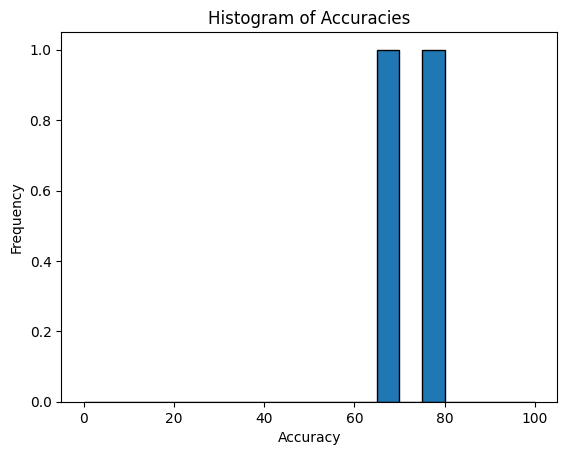

In [14]:
from matplotlib import pyplot as plt

from src.models.mlp import MLPEvaluator


def hist_accuracies(accuracies: list[float]) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=20, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies(df["Accuracy"])

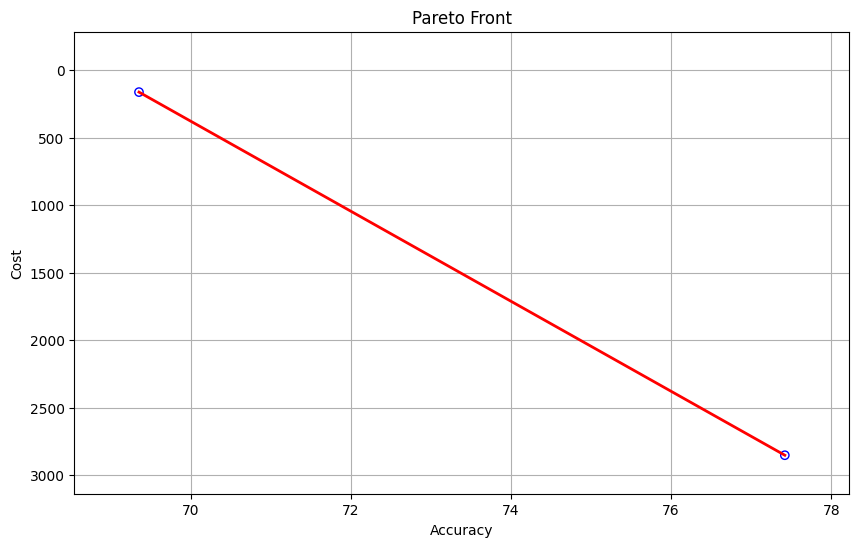

In [15]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])